In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
cd /content/drive/MyDrive/Prob_Stats

/content/drive/MyDrive/Prob_Stats


In [3]:
ls

 catboost_info/               starbucks_drinkMenu_expanded.csv
'Hypothesis_Testing .ipynb'   starbucks-menu-nutrition-drinks.csv
 Milestone2_starter.ipynb     starbucks-menu-nutrition-food.csv
'Nutrition_EDA .ipynb'


In [ ]:
# !pip install category_encoders

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from category_encoders import HashingEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score
import seaborn as sns
from scipy import stats
# from scipy.stats.stats import pearsonr, spearmanr

In [6]:
coffee = pd.read_csv("starbucks_drinkMenu_expanded.csv")

In [7]:
# Data Cleaning
# Notes
# 1. Stupid (g) in each column, need to remove that.
# 2. One of the total fat rows has a typo
# 3. All column datatypes needed to be fixed.
# 4. Caffeine has an issue for all Tazo drinks. It says "Varies." For now, I converted them to None and then 0.

# rename columns - remove units from the name 
coffee = coffee.rename(columns={' Total Fat (g)': 'Total Fat', 'Trans Fat (g) ':'Trans Fat', 'Saturated Fat (g)':'Saturated Fat',
       ' Sodium (mg)':'Sodium', ' Total Carbohydrates (g) ':'Total Carbohydrates', 'Cholesterol (mg)':'Cholesterol',
       ' Dietary Fibre (g)':'Dietary Fibre', ' Sugars (g)':'Sugars', ' Protein (g) ':'Protein',
       'Vitamin A (% DV) ':'Vitamin A', 'Vitamin C (% DV)':'Vitamin C', ' Calcium (% DV) ':'Calcium',
       'Iron (% DV) ':'Iron', 'Caffeine (mg)':'Caffeine'})

# one of the total_fat rows has a typo 
coffee.loc[237, 'Total Fat'] = 3.2

# the following columns have % sign with the numerical 
coffee = coffee.replace({'Vitamin A': {'%': ''}, 'Vitamin C': {'%': ''},
                                     'Calcium': {'%': ''}, 'Iron': {'%': ''}}, regex=True)

coffee = coffee.replace('varies', None)
coffee = coffee.replace('Varies', None)

# fix data types 
coffee['Total Fat'] = coffee['Total Fat'].astype('float')
coffee['Vitamin A'] = coffee['Vitamin A'].astype('float')
coffee['Vitamin C'] = coffee['Vitamin C'].astype('float')
coffee['Calcium'] = coffee['Calcium'].astype('float')
coffee['Iron'] = coffee['Iron'].astype('float')
coffee['Caffeine'] = coffee['Caffeine'].astype('float')


# change grams to milligrams to ensure all columns are of same unit 
coffee['Sodium'] /=1000
coffee['Cholesterol'] /=1000
coffee['Vitamin A'] /=100
coffee['Vitamin C'] /=100
coffee['Calcium'] /=100
coffee['Iron'] /=100
coffee['Caffeine'] /=1000


coffee = coffee.fillna(0)


# Outlier Detection -
## Drop everything outside 3 standard deviations

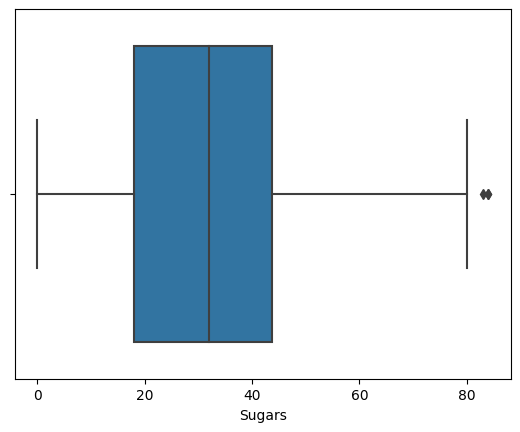

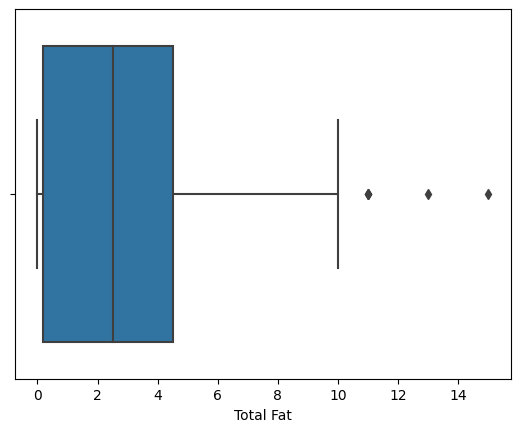

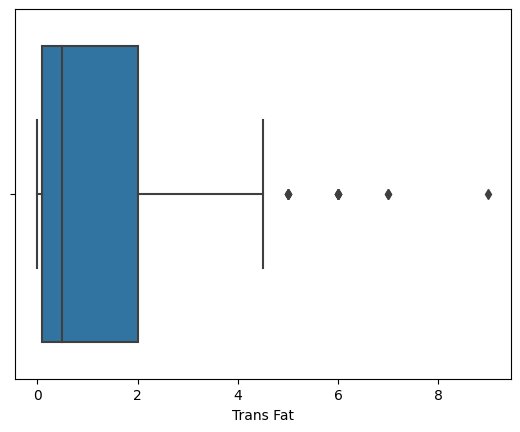

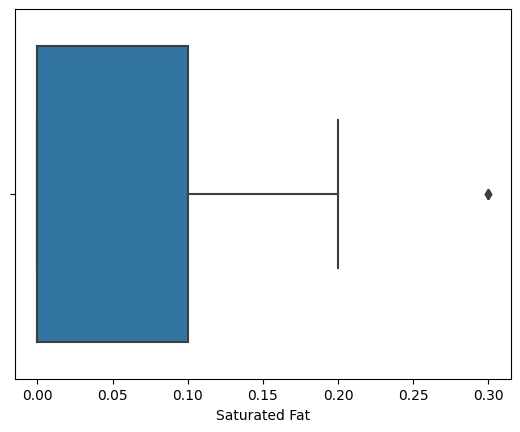

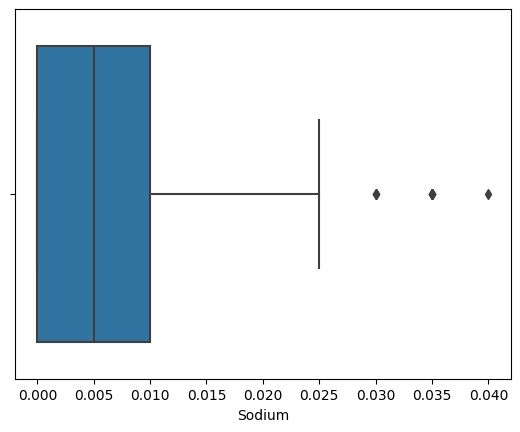

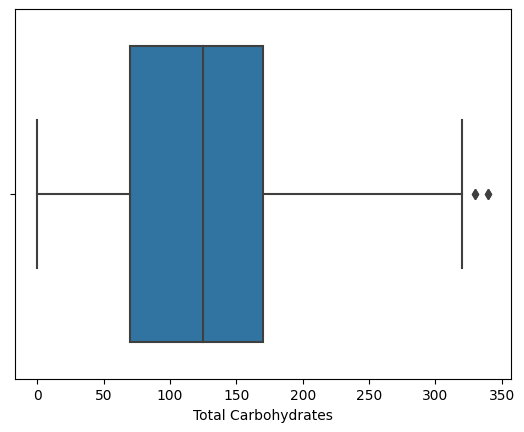

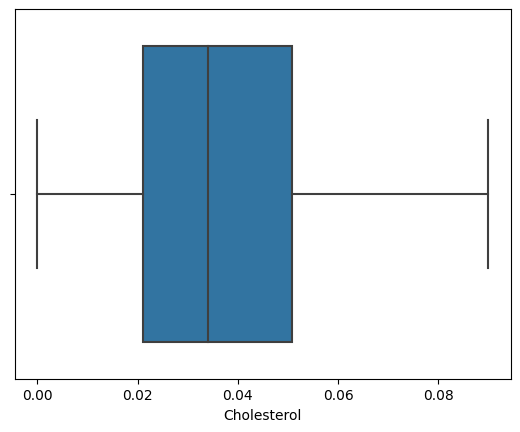

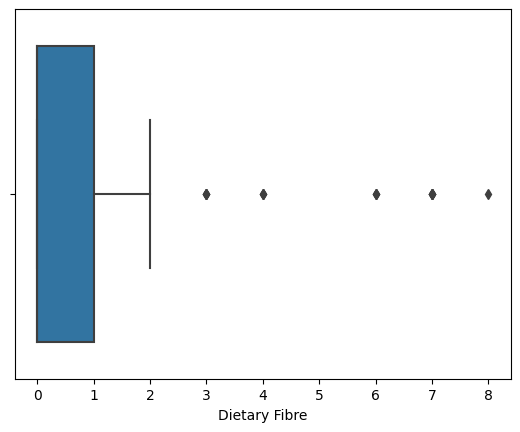

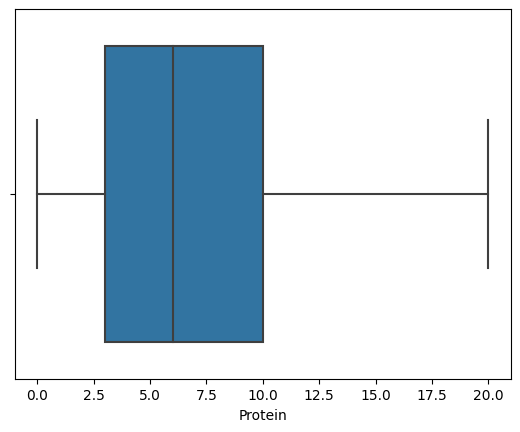

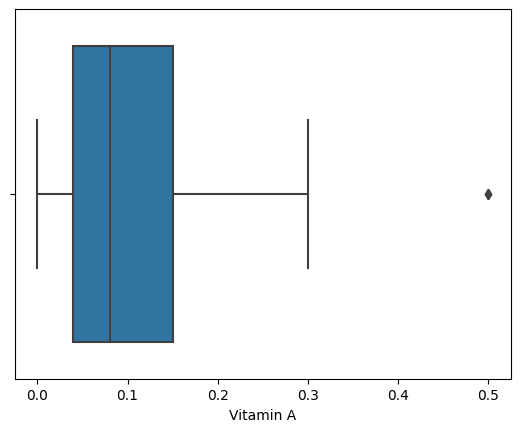

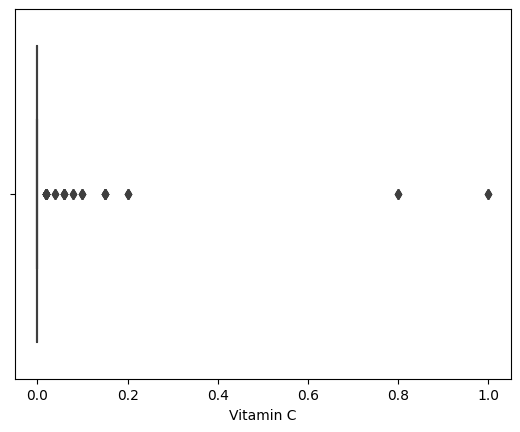

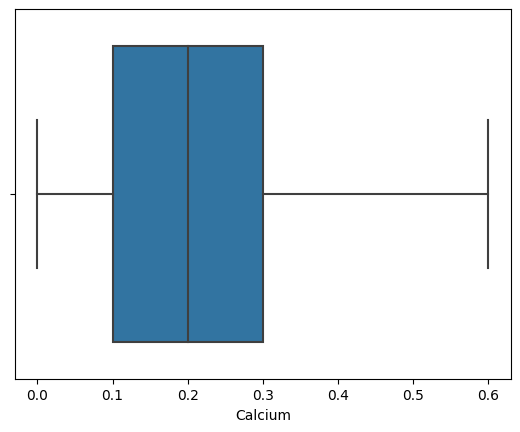

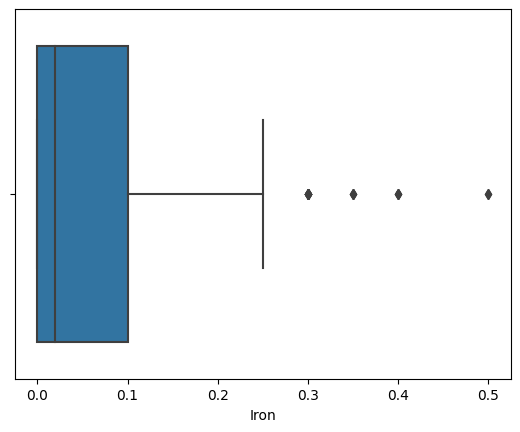

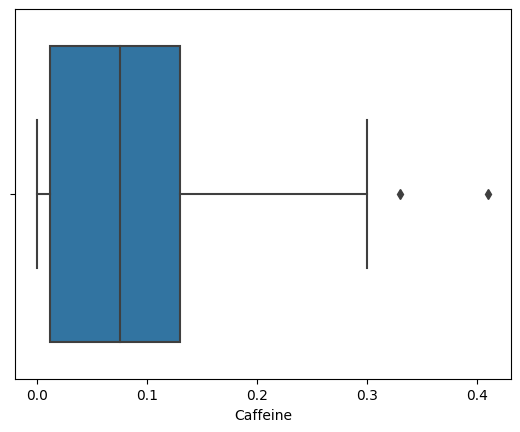

In [8]:
import seaborn as sns
sns.boxplot(data=coffee,x=coffee['Sugars'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Total Fat'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Trans Fat'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Saturated Fat'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Sodium'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Total Carbohydrates'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Cholesterol'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Dietary Fibre'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Protein'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Vitamin A'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Vitamin C'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Calcium'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Iron'])
plt.show()
sns.boxplot(data=coffee,x=coffee['Caffeine'])
plt.show()

In [9]:
for columns in coffee.drop(columns = ['Beverage_category','Beverage','Beverage_prep', 'Calories']).columns:
    z=np.abs(stats.zscore(coffee[str(columns)]))
    coffee[str(columns)][z>3] = np.nan
    coffee[str(columns)] = coffee[str(columns)].fillna(coffee[str(columns)].mean())

<ipython-input-9-b02a0943ca69>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coffee[str(columns)][z>3] = np.nan


In [10]:
coffee.shape

(242, 18)

# Address multi-colinearity

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


columns = coffee.drop(columns = ['Beverage_category','Beverage','Beverage_prep', 'Calories']).columns
vif_data = pd.DataFrame()
vif_data["Feature"] = columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(coffee.drop(columns = ['Beverage_category',
                                                                    'Beverage',
                                                                    'Beverage_prep',
                                                                    'Calories']).values, i)
                          for i in range(len(columns))]
  
print(vif_data)

                Feature          VIF
0             Total Fat    15.039208
1             Trans Fat     7.107078
2         Saturated Fat     8.848957
3                Sodium    12.029978
4   Total Carbohydrates    12.642810
5           Cholesterol  1480.878508
6         Dietary Fibre     6.901136
7                Sugars  1344.724208
8               Protein   107.529459
9             Vitamin A    43.526729
10            Vitamin C     1.738555
11              Calcium    56.538466
12                 Iron     4.124238
13             Caffeine     2.910847


# Gotta drop something -- either Sugars or Cholestrol

In [12]:
coffee = coffee.drop(columns = ['Sugars']) #['Cholestrol']

In [13]:
coffee.shape

(242, 17)

# Begin Modeling

In [14]:
# Train test split before any feature encodings : Lessons from ML in Finance, RIP
X = coffee.loc[:, coffee.columns!='Calories']
y = coffee.loc[:, 'Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

In [15]:
X.nunique()

Beverage_category       9
Beverage               33
Beverage_prep          13
Total Fat              23
Trans Fat              17
Saturated Fat           4
Sodium                  8
Total Carbohydrates    51
Cholesterol            75
Dietary Fibre           6
Protein                26
Vitamin A              11
Vitamin C               9
Calcium                14
Iron                   12
Caffeine               32
dtype: int64

In [16]:
# Beverage_category, Beverage and Beverage_prep are the 3 categorical columns.
# Beverage category has 9, Beverage has 33 and Beverage_prep 13, so if we get dummies for everything, 
# that will be terrible. Too many columns.

# So I got one-hot for the smallest number of categories : Beverage_category

# X_train = pd.get_dummies(X_train, columns = ['Beverage_category'])
# X_test = pd.get_dummies(X_test, columns = ['Beverage_category'])

#For the remaining 2, we use fancy shit : Hashing Encoder. Converts 46 labels to 8.

hash_ = HashingEncoder(cols=['Beverage', 'Beverage_prep', 'Beverage_category'], n_components=8)
X_train = hash_.fit_transform(X_train)
X_test = hash_.fit_transform(X_test)

In [17]:
# Function defined for SelectKBest. 
# Reference : https://machinelearningmastery.com/feature-selection-for-regression-data/

def select_features(X_train, y_train, X_test, k):
    fs = SelectKBest(score_func=f_regression, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [18]:
def eval_model(y_test, predictions):
    #print("RMSE: ", np.round(np.sqrt(mean_squared_error(y_test, predictions)),4))
    print("MAE: ", np.round(mean_absolute_error(y_test, predictions),4))
    #print("Max Error: ", np.round(max_error(y_test, predictions), 4))
    #print("Percentage Error:", round(mean_absolute_error(y_test, predictions) / coffee['Calories'].mean(), 4))
    return None

k = 1 mean =-26.277
k = 2 mean =-25.374
k = 3 mean =-15.602
k = 4 mean =-14.797
k = 5 mean =-11.606
k = 6 mean =-8.960
k = 7 mean =-8.076
k = 8 mean =-6.966
k = 9 mean =-6.436
k = 10 mean =-6.514
k = 11 mean =-6.494
k = 12 mean =-6.271
k = 13 mean =-6.389
k = 14 mean =-6.323
k = 15 mean =-6.361
k = 16 mean =-6.198
k = 17 mean =-6.295
k = 18 mean =-6.388
k = 19 mean =-6.257
k = 20 mean =-6.165
k = 21 mean =-6.165


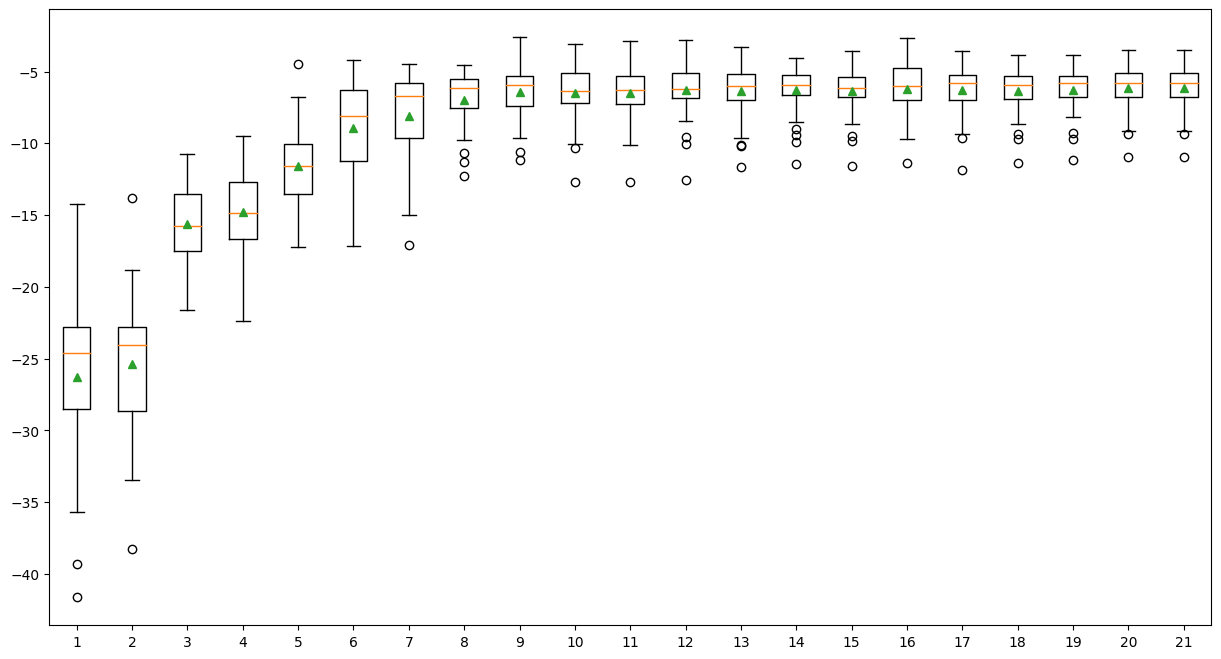

In [19]:
# Find out the best k using RepeatedKFold and Neggie MAE

num_features = [i for i in range(1, X_train.shape[1]+1)]
results = list()
for k in num_features:
    model = LinearRegression()
    fs = SelectKBest(score_func=mutual_info_regression, k=k)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # Get columns to keep and create new dataframe with those only
    
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results.append(scores)
    # summarize the results
    print('k = %d mean =%.3f' % (k, np.mean(scores)))
# plot model performance for comparison
plt.figure(figsize=(15, 8))
plt.boxplot(results, labels=num_features, showmeans=True)
plt.show()

In [20]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, 19)
# fit the model
model = LinearRegression()
model.fit(X_train_fs, y_train)
# cols_idxs = fs.get_support(indices=True)
# features_df_new = X_train.iloc[:,cols_idxs]
# evaluate the model
yhat = model.predict(X_test_fs)
eval_model(y_test, yhat)

MAE:  5.858


In [21]:
df = pd.DataFrame(y_test)
indices = df.index
df.reset_index(drop=True, inplace=True)

df1 = pd.DataFrame(yhat, columns=['prediction'])
df1.reset_index(drop=True, inplace=True)

df2 = pd.concat([df, df1], axis=1) 
df2.index = indices

In [22]:
df2['error'] = np.abs(df2['Calories'] - df2['prediction'])
df2 = df2.sort_values(by = ['error'], ascending=False) 

In [23]:
pd.concat([df2, coffee], axis=1, join="inner")[:15]

,Calories,prediction,error,Beverage_category,Beverage,Beverage_prep,Calories,Total Fat,Trans Fat,Saturated Fat,Sodium,Total Carbohydrates,Cholesterol,Dietary Fibre,Protein,Vitamin A,Vitamin C,Calcium,Iron,Caffeine
84,510,452.677547,57.322453,Signature Espresso Drinks,White Chocolate Mocha (Without Whipped Cream),2% Milk,510,2.8125,1.227197,0.2,0.005614,330,0.077,0.000000,19.0,0.200000,0.040000,0.60,0.02,0.150
177,270,250.613894,19.386106,Smoothies,Orange Mango Banana Smoothie,Soymilk,270,1.5000,0.400000,0.0,0.005000,120,0.053,0.575107,15.0,0.093264,0.014534,0.10,0.06,0.000
15,190,172.054417,17.945583,Classic Espresso Drinks,Caffè Latte,Soymilk,190,7.0000,1.000000,0.0,0.000000,170,0.016,2.000000,13.0,0.200000,0.000000,0.50,0.25,0.150
198,350,365.971620,15.971620,Frappuccino® Blended Coffee,Mocha (Without Whipped Cream),Soymilk,350,3.0000,1.000000,0.0,0.000000,290,0.078,2.000000,6.0,0.060000,0.000000,0.20,0.20,0.140
126,310,297.761274,12.238726,Tazo® Tea Drinks,Tazo® Green Tea Latte,Soymilk,310,6.0000,1.000000,0.0,0.000000,140,0.050,3.000000,11.0,0.150000,0.150000,0.45,0.25,0.080
63,120,109.363118,10.636882,Signature Espresso Drinks,Caramel Macchiato,2% Milk,120,4.0000,2.000000,0.1,0.015000,80,0.016,0.000000,5.0,0.100000,0.000000,0.15,0.00,0.075
77,270,280.545582,10.545582,Signature Espresso Drinks,White Chocolate Mocha (Without Whipped Cream),Tall Nonfat Milk,270,4.5000,3.500000,0.0,0.005000,190,0.047,0.000000,12.0,0.150000,0.020000,0.35,0.00,0.075
13,170,159.999724,10.000276,Classic Espresso Drinks,Caffè Latte,Venti Nonfat Milk,170,0.4000,0.300000,0.0,0.010000,190,0.025,0.000000,16.0,0.300000,0.000000,0.50,0.00,0.150
26,340,349.963379,9.963379,Classic Espresso Drinks,Caffè Mocha (Without Whipped Cream),2% Milk,340,11.0000,6.000000,0.2,0.030000,180,0.053,2.000000,17.0,0.200000,0.020000,0.45,0.30,0.180
190,180,189.607926,9.607926,Frappuccino® Blended Coffee,Mocha (Without Whipped Cream),Tall Nonfat Milk,180,0.5000,0.400000,0.0,0.000000,150,0.042,1.000000,3.0,0.040000,0.000000,0.10,0.08,0.130


Text(0.5, 1.0, 'Actual Calories - Predicted Calories')

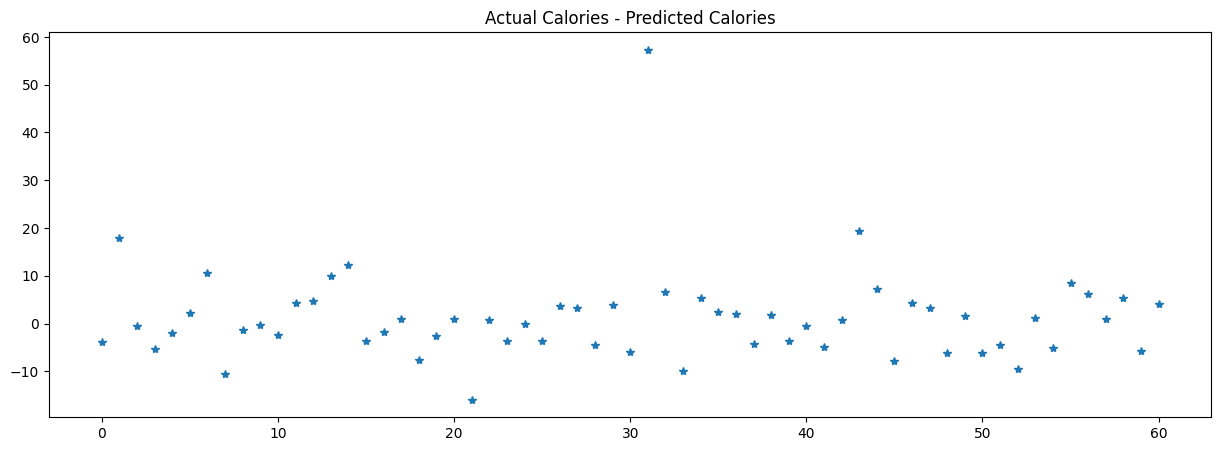

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(np.array(y_test) - yhat, "*")
plt.title("Actual Calories - Predicted Calories")

<Axes: xlabel='Calories', ylabel='Density'>

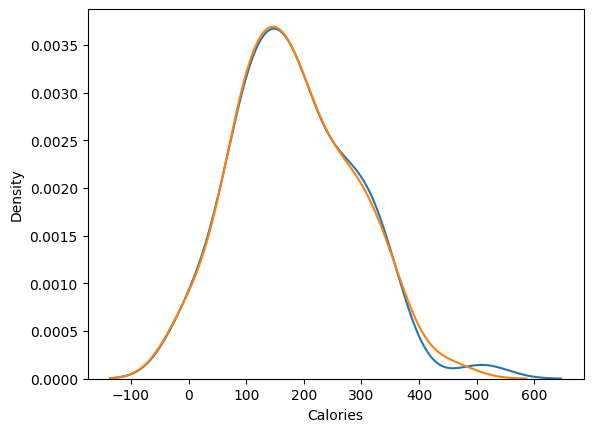

In [25]:
# This looks HOT. Amazing predictions.

sns.kdeplot(y_test)
sns.kdeplot(yhat)

# XGBoost

In [26]:
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

X_train = pd.get_dummies(X_train, columns = ['Beverage_category'])
X_test = pd.get_dummies(X_test, columns = ['Beverage_category'])

#For the remaining 2, we use fancy shit : Hashing Encoder. Converts 46 labels to 8.

hash_ = HashingEncoder(cols=['Beverage', 'Beverage_prep'], n_components=8)
X_train = hash_.fit_transform(X_train)
X_test = hash_.fit_transform(X_test)

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgbr = xgb.XGBRegressor(objective='reg:squarederror',seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))
 
# ypred = xgbr.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
Lowest RMSE:  16.923786280013864


In [27]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror',seed = 20, colsample_bytree= 0.7, learning_rate =0.05
                        , max_depth = 3, n_estimators =  1000)
xgbr.fit(X_train, y_train)
ypred = xgbr.predict(X_test)
eval_model(y_test, ypred)

MAE:  8.6043


Text(0.5, 1.0, 'Actual Calories - Predicted Calories(XGBOOST)')

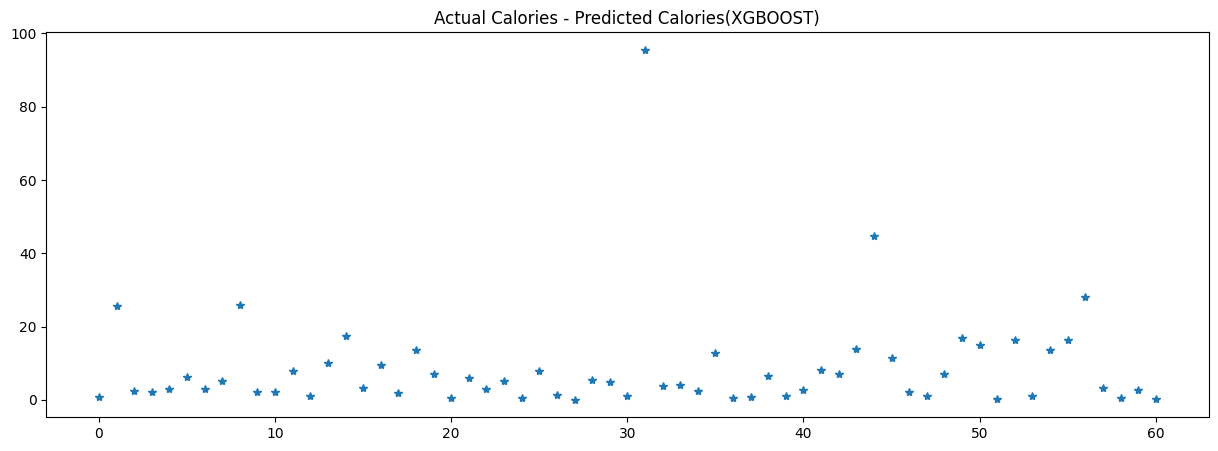

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(np.abs(np.array(y_test) - ypred), "*")
plt.title("Actual Calories - Predicted Calories(XGBOOST)")

In [34]:
df = pd.DataFrame(y_test)
indices = df.index
df.reset_index(drop=True, inplace=True)

df1 = pd.DataFrame(ypred, columns=['prediction'])
df1.reset_index(drop=True, inplace=True)

df2 = pd.concat([df, df1], axis=1) 
df2.index = indices

df2['error'] = np.abs(df2['Calories'] - df2['prediction'])
df2 = df2.sort_values(by = ['error'], ascending=False) 

pd.concat([df2, coffee], axis=1, join="inner")[:15]

,Calories,prediction,error,Beverage_category,Beverage,Beverage_prep,Calories,Total Fat,Trans Fat,Saturated Fat,Sodium,Total Carbohydrates,Cholesterol,Dietary Fibre,Protein,Vitamin A,Vitamin C,Calcium,Iron,Caffeine
84,510,414.444824,95.555176,Signature Espresso Drinks,White Chocolate Mocha (Without Whipped Cream),2% Milk,510,2.8125,1.227197,0.2,0.005614,330,0.077,0.000000,19.0,0.200000,0.040000,0.60,0.02,0.150
228,290,334.604858,44.604858,Frappuccino® Light Blended Coffee,Java Chip,Venti Nonfat Milk,290,5.0000,4.000000,0.0,0.005000,320,0.058,2.000000,7.0,0.080000,0.000000,0.15,0.35,0.165
212,340,367.932739,27.932739,Frappuccino® Blended Coffee,Java Chip (Without Whipped Cream),Whole Milk,340,7.0000,5.000000,0.1,0.010000,250,0.067,2.000000,5.0,0.040000,0.000000,0.10,0.25,0.110
220,110,135.780762,25.780762,Frappuccino® Light Blended Coffee,Mocha,Tall Nonfat Milk,110,0.5000,0.400000,0.0,0.000000,150,0.024,1.000000,3.0,0.040000,0.000000,0.08,0.06,0.070
15,190,164.324875,25.675125,Classic Espresso Drinks,Caffè Latte,Soymilk,190,7.0000,1.000000,0.0,0.000000,170,0.016,2.000000,13.0,0.200000,0.000000,0.50,0.25,0.150
126,310,292.685272,17.314728,Tazo® Tea Drinks,Tazo® Green Tea Latte,Soymilk,310,6.0000,1.000000,0.0,0.000000,140,0.050,3.000000,11.0,0.150000,0.150000,0.45,0.25,0.080
124,290,273.032654,16.967346,Tazo® Tea Drinks,Tazo® Green Tea Latte,Grande Nonfat Milk,290,0.5000,0.200000,0.0,0.010000,160,0.057,1.000000,14.0,0.250000,0.150000,0.45,0.04,0.080
190,180,196.337906,16.337906,Frappuccino® Blended Coffee,Mocha (Without Whipped Cream),Tall Nonfat Milk,180,0.5000,0.400000,0.0,0.000000,150,0.042,1.000000,3.0,0.040000,0.000000,0.10,0.08,0.130
11,190,173.790039,16.209961,Classic Espresso Drinks,Caffè Latte,2% Milk,190,7.0000,3.500000,0.2,0.030000,170,0.019,0.000000,12.0,0.200000,0.020000,0.40,0.00,0.150
223,100,115.010696,15.010696,Frappuccino® Light Blended Coffee,Caramel,Tall Nonfat Milk,100,0.1000,0.000000,0.0,0.000000,140,0.023,0.000000,3.0,0.040000,0.000000,0.08,0.00,0.065


In [29]:
# !pip install catboost

In [30]:
import catboost as cb
model = cb.CatBoostRegressor(loss_function='RMSE')
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.05,0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

ModuleNotFoundError: ignored

In [ ]:
model.get_all_params()

In [ ]:
eval_model(y_test, pred)

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(np.array(y_test) - pred, "*")
plt.title("Actual Calories - Predicted Calories (CATBOOST)")

# Junk

In [ ]:

threshold=3
# z=np.abs(stats.zscore(coffee['Sugars']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Total Fat']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Trans Fat']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Saturated Fat']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Sodium']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Total Carbohydrates']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Cholesterol']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Dietary Fibre']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Protein']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Vitamin A']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Vitamin C']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Calcium']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Iron']))
# coffee = coffee[z<3]
# z=np.abs(stats.zscore(coffee['Caffeine']))
# coffee = coffee[z<3]

In [ ]:
coffee[84:85]